In [ ]:
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path as pt
import torch
import torchaudio
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio import transforms
from torchvision.transforms import v2
# from Moduls.MosreDataset import MosreDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.parallel import DataParallel
from collections import Counter
import math
DIVICE = torch.device("cuda")

MAIN = pt(os.getcwd())
DATASET_PATCH = MAIN / 'morse_dataset'
AUDIO_FILES = DATASET_PATCH / 'morse_dataset'

# Поятоянные значения выявленные в процессе анализа
MORSEALP = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#"
MAX_TIME = 48
SAMPLE_RATE = 8000
N_MELS = 128
N_FFT = 400
HOP_LENGTH = 180
TOP_DB = 80
FREQ_MASK = 15
TIME_MASK = 20

# Гиперпараметы обучения
SEED = 42
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.0002 #2e-4
WEIGHT_DECAY = 0.00001
# int_to_alph = dict(enumerate(MORSEALP))
# alph_to_int = {char:enum for enum, char in int_to_alph.items()}

#===== Import data =====
train_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'train.csv'))
test_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'test.csv'))
sample_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'sample_submission.csv'))

all_chars = Counter("".join(train_data['message']))
BLANK_CHAR = "_"
vocab_list = sorted(all_chars.keys()) + [BLANK_CHAR]
num_classes = len(vocab_list)
char_to_int = {char: i for i, char in enumerate(vocab_list)}
int_to_char = {i: char for i, char in enumerate(vocab_list)}
BLANK_IDX = char_to_int[BLANK_CHAR]

class MosreDataset(Dataset):
    """
    Класс для обработки 
    """
    def __init__(self, df, data_patch,char_to_int, train=True, transforms=None, prev_chars = 1):
        self.df = df
        self.is_train = train

        self.data_path = data_patch
        self.audio_paths = self.data_path / 'morse_dataset'

        self.transforms = transforms

        self.char_to_int = char_to_int
        self.prev_chars = prev_chars

        if self.is_train:
            self.messeges = self.df.message.values

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #Получение аугментрованых спектрограмм
        try:
            audio_file = self.audio_paths / self.df.id.values[index]
            waveform, sample_rate = torchaudio.load(audio_file)
            augmented_spectrogram = self.transforms(waveform)
            spec_lens = augmented_spectrogram.shape[-1]
            if self.is_train:
                message = self.messeges[index]
                #Получение списка индексов секта - как требует CTC los
                '''
                При обработке dataloader labels будут выравниваться по макс длине для выравнивания батча
                Т.е. будет padding 0. что в будующем будет пустым значением для ctc loss
                '''
                target = torch.tensor([self.char_to_int[char] for char in message], dtype=torch.long); 
                target_len = torch.tensor(len(target), dtype=torch.long)
                return augmented_spectrogram, spec_lens, target ,target_len, message
            else:
                return augmented_spectrogram,spec_lens, None, None, None
        except Exception as ex:
            print(str(ex))
        
    def change_time(self, audio_file, max_len = 384000):
        waveform, sample_rate = torchaudio.load(audio_file)
        cahanal, sig_len = waveform.shape

        if sig_len < max_len:
            pad_len = torch.zeros(max_len - sig_len).unsqueeze(0)
            waveform = torch.cat([waveform, pad_len], dim=1)

        return waveform
    
FIRST_FE_COUNT = 16
SECOND_FE_COUNT = 32
THIRD_FE_COUNT = 32
QAD_FE_COUNT = 32
PADDING = 'same'
MAXPOOL_KERNEL = 2
KERTNEL_SIZE = 3
NERON_COUNT = 128
GRU_HIDEN = 256

# Start with 4 transforms
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)  # [B, C, 1, 1]
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction),  # [B, C/reduction]
            nn.GELU(),
            nn.Linear(channels // reduction, channels),  # [B, C]
            nn.Sigmoid()
        )
    
    def forward(self, x):
        B, C, _, _ = x.shape
        squeezed = self.squeeze(x).view(B, C)  # [B, C]
        weights = self.excitation(squeezed).view(B, C, 1, 1)  # [B, C, 1, 1]
        return x * weights  # Масштабируем каналы
    
class Embedding(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=FIRST_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(FIRST_FE_COUNT),
            SEBlock(FIRST_FE_COUNT, 4),
            nn.GELU(),
            nn.MaxPool2d((1, 2), (1, 2)), # [batch, FIRST_FE_COUNT = 16, 64, 960]

            nn.Conv2d(in_channels=FIRST_FE_COUNT, 
                      out_channels=SECOND_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(SECOND_FE_COUNT),
            nn.GELU(),
            SEBlock(SECOND_FE_COUNT, 8),
            nn.MaxPool2d((2, 1), (2, 1)), # [batch, SECOND_FE_COUNT = 32, 32, 480]

            nn.Conv2d(in_channels=SECOND_FE_COUNT, 
                      out_channels=THIRD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(THIRD_FE_COUNT),
            nn.GELU(),
            SEBlock(THIRD_FE_COUNT, 16),
            nn.MaxPool2d((2, 2), (2, 2)), # [batch, THIRD_FE_COUNT = 32, 16, 240]

            nn.Conv2d(in_channels=THIRD_FE_COUNT, 
                      out_channels=QAD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(QAD_FE_COUNT, 16),
            nn.GELU(),
            SEBlock(QAD_FE_COUNT),
            nn.MaxPool2d((2, 1), (2, 1)) # [batch=32, QAD_FE_COUNT = 32, 16, 89](что юы сохраниить большще признаков по горизонтали)
        )
        self.cnn_output_features = 0
        self.layer1 = nn.Linear(self.cnn_output_features, N_MELS*2); 
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.net_conv(x)
        return x

class PositionalEncoding(nn.Module): # класический
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x
    
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(self).__init__()
        self.self_attn = nn.MultiHeadAttention(d_model, num_heads)
        self.feed_forward = nn.PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

    def _get_output_lengths(self, input_lengths):
        output_lengths = torch.floor(input_lengths.float() / 4); 
        return torch.clamp(output_lengths.long(), min=1)
    

train_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    transforms.FrequencyMasking(freq_mask_param=FREQ_MASK),
    transforms.TimeMasking(time_mask_param=TIME_MASK),
    # v2.RandomCrop((N_MELS, 1920)) # Обрезает последний кадр спектрограммы, в идеале надобы считать а не прописывать число
    ) # заметка - Данные трансформации не создают довых обучаемых параметров. Но есть и те что создают. В будущем это стоит учитывать

valid_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    # v2.CenterCrop((N_MELS, 1920)) 
    )

train_dataframe, val_dataframe = train_test_split(train_data, test_size=0.15, random_state=SEED)

train_ds = MosreDataset(df=train_dataframe,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=True,
                        transforms=train_audio_transforms)

val_ds = MosreDataset(df=val_dataframe,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=True,
                        transforms=valid_audio_transforms)


def my_collate(batch):
    spectrograms = [item[0].squeeze(0) for item in batch]
    # Падинг спектрограмм по максимальной длине
    spectrograms_permuted = [s.permute(1, 0) for s in spectrograms]
    spectrograms_padded = nn.utils.rnn.pad_sequence(spectrograms_permuted, batch_first=True, padding_value=0.0)
    spectrograms_padded = spectrograms_padded.permute(0, 2, 1).unsqueeze(1)
    # spec_lens = torch.stack([item[0] for item in batch])
    spec_lens = torch.tensor([item[1] for item in batch]).reshape(BATCH_SIZE)
    if batch[0][3] is not None:
        target = torch.nn.utils.rnn.pad_sequence(
                                                [item[2] for item in batch], 
                                                batch_first=True, 
                                                padding_value=BLANK_IDX)# выравнивает последовательность до макс 
                                                                        # длины в батче заполняя пропуски нулем
        label_len = torch.stack([item[3] for item in batch])
        msg = [item[4] for item in batch]
        
        return [spectrograms_padded, spec_lens, target, label_len, msg]
    else: 
        return spectrograms_padded

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate, drop_last=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate, drop_last=True)

# test, test_lens, test_target, _, mess = next(iter(train_dl))
# test, test_target= test.to(DIVICE), test_target.to(DIVICE)

# test_val, val_lens, val_target, __, val_mess = next(iter(val_dl))
# test_val, val_target = test_val.to(DIVICE), val_target.to(DIVICE)
# test.shape 


In [34]:
key_padding_mask = torch.zeros(32, 10, dtype=torch.bool)  # (batch_size, sequence_length)
key_padding_mask[:, 5:] = 1
key_padding_mask

tensor([[False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, Fal

In [ ]:
def _get_output_lengths(x, input_lengths):
    output_lengths = torch.floor(input_lengths.float() / 4); 
    return torch.clamp(output_lengths.long(), min=1)
    

In [33]:
next(iter(train_dl))[1]

_get_output_lengths(torch.tensor([100,100,100,324,100,500]))

tensor([ 25,  25,  25,  81,  25, 125])

In [ ]:
#===== начало обучения =====
model = MorseNet(num_classes=num_classes).to(DIVICE)
# model = DataParallel(model)
optimizer = optim.Adam(params=model.parameters(), lr=0.002)  # Было 0.002
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
loss_func = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True).to(DIVICE)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nMorseNet - инициалицация модели. Число обучаемых параметров: {total_params:,}")

In [3]:
model = Embedding(num_classes=num_classes).to(DIVICE)
emb_out = model(test)
emb_out

c:\Users\homer\OneDrive\Desktop\Morse_Decoder_V2\Morse_decoder_V2\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NotImplementedError: Module [Embedding] is missing the required "forward" function

# Обучение модели

In [2]:
import Levenshtein
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu() 
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy() # арзмакс по лагитам и преобразование к словарю
    
    for ind in max_inds:
        merged_inds = []
        for idx in ind:
            if idx != blank_label_idx: 
                merged_inds.append(idx)
        text = "".join([int_char_map.get(i, '?') for i in merged_inds])
        preds.append(text)

    return preds


In [3]:
lst_loss_train = []
lst_loss_val = []
best_val_loss = 0
for epoch in range(EPOCHS):
    model.train()

    epoch_train_loss = 0.0
    train_predicts = []

    train_tqdm = tqdm(train_dl, desc=f"Эпоха {epoch+1}/{EPOCHS} [Обучение]", leave=False)
    for batch_ind, batch in enumerate(train_tqdm):
        mel_spec, targets, targets_lens, _ = batch
        mel_spec, targets, targets_lens = mel_spec.to(DIVICE), targets.to(DIVICE), targets_lens.to(DIVICE)

        #===== считатем длинну mel_spec для передачи в CTC loss =====
        
        optimizer.zero_grad()
        predict = model(mel_spec) # (N=batch,T,C)
        N = predict.shape[1]
        T = predict.shape[0]
        predict_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

        try:
            loss = loss_func(predict, targets, predict_lengths, targets_lens.reshape(BATCH_SIZE))
        except RuntimeError:
            print(predict.shape, targets.shape, predict_lengths, targets_lens.reshape(BATCH_SIZE))
            continue

        if torch.isnan(loss) or torch.isinf(loss): 
            print(f"\nWarning: In batch-{batch_ind} loss train is NaN/Inf: {loss.item()}"); 
            optimizer.zero_grad(); 
            continue

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_train_loss += loss.item()

    total_train = epoch_train_loss / len(train_dl)

    # ======== Валидация ========
    model.eval()
    val_loss = 0.0
    total_val = 0
    val_predicts = []

    with torch.no_grad():
        for val_mel_spec, val_labels, val_label_lensin, _ in tqdm(
                                                        val_dl, 
                                                        desc=f"Эпоха {epoch+1}/{EPOCHS} [Валидация]", 
                                                        leave=False):
            val_mel_spec, val_labels, val_label_lensin = val_mel_spec.to(DIVICE), val_labels.to(DIVICE), val_label_lensin.to(DIVICE)
            val_predict = model(val_mel_spec)

            val_N = val_predict.shape[1]
            val_T = val_predict.shape[0]
            predict_val_lengths = torch.full(size=(val_N,), fill_value=val_T, dtype=torch.long)
            val_loss += loss_func(val_predict, val_labels, predict_val_lengths, val_label_lensin).item()

    total_val = val_loss / len(val_dl)

    lst_loss_train.append(total_train)
    lst_loss_val.append(total_val)

    scheduler.step(total_val)

    print(f"\n===== Эпоха {epoch+1}/{EPOCHS} =====")\
    #===== Инфо про градиенты=====
    grad_norms = [param.grad.norm().item() for param in model.parameters() if param.grad is not None]
    if grad_norms:
        print(f"Mean grad norm: {np.mean(grad_norms):.6f}")
        print(f"Max grad norm: {np.max(grad_norms):.6f}")
        print(f"Min grad norm: {np.min(grad_norms):.6f}")
    else:
        print("No gradients computed yet.")
    #===== Инфо про шаг обучения и данные по потерям =====
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current LR: {current_lr:.6f}")
    print(f"---- Train Loss: {total_train:.4f}")
    print(f"---- Val Loss: {total_val:.4f}")
    if current_lr <= 1e-6:
        print("Learning rate достиг минимума 1e-6, остановка обучения")
        break
    print("-" * 50)


===== Эпоха 1/50 =====
Mean grad norm: 0.022087
Max grad norm: 0.972216
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 4.1686
---- Val Loss: 4.0351
--------------------------------------------------



===== Эпоха 2/50 =====
Mean grad norm: 0.070542
Max grad norm: 0.553876
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 2.5585
---- Val Loss: 0.5602
--------------------------------------------------



===== Эпоха 3/50 =====
Mean grad norm: 0.062897
Max grad norm: 0.666260
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.5613
---- Val Loss: 0.2444
--------------------------------------------------



===== Эпоха 4/50 =====
Mean grad norm: 0.064604
Max grad norm: 0.507543
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.4149
---- Val Loss: 0.2004
--------------------------------------------------



===== Эпоха 5/50 =====
Mean grad norm: 0.036125
Max grad norm: 0.298841
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3610
---- Val Loss: 0.1687
--------------------------------------------------



===== Эпоха 6/50 =====
Mean grad norm: 0.053615
Max grad norm: 0.396670
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3298
---- Val Loss: 0.1658
--------------------------------------------------



===== Эпоха 7/50 =====
Mean grad norm: 0.062139
Max grad norm: 0.654993
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3147
---- Val Loss: 0.1561
--------------------------------------------------



===== Эпоха 8/50 =====
Mean grad norm: 0.062966
Max grad norm: 0.541432
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2982
---- Val Loss: 0.1773
--------------------------------------------------



===== Эпоха 9/50 =====
Mean grad norm: 0.063755
Max grad norm: 0.800694
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2886
---- Val Loss: 0.1504
--------------------------------------------------



===== Эпоха 10/50 =====
Mean grad norm: 0.055470
Max grad norm: 0.503541
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2750
---- Val Loss: 0.1482
--------------------------------------------------



===== Эпоха 11/50 =====
Mean grad norm: 0.038079
Max grad norm: 0.273240
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2717
---- Val Loss: 0.1417
--------------------------------------------------



===== Эпоха 12/50 =====
Mean grad norm: 0.063230
Max grad norm: 0.423697
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2613
---- Val Loss: 0.1511
--------------------------------------------------



===== Эпоха 13/50 =====
Mean grad norm: 0.049591
Max grad norm: 0.304322
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2553
---- Val Loss: 0.1456
--------------------------------------------------



===== Эпоха 14/50 =====
Mean grad norm: 0.037707
Max grad norm: 0.230941
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2473
---- Val Loss: 0.1391
--------------------------------------------------



===== Эпоха 15/50 =====
Mean grad norm: 0.046601
Max grad norm: 0.380733
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2470
---- Val Loss: 0.1453
--------------------------------------------------



===== Эпоха 16/50 =====
Mean grad norm: 0.046754
Max grad norm: 0.395047
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2385
---- Val Loss: 0.1394
--------------------------------------------------



===== Эпоха 17/50 =====
Mean grad norm: 0.045973
Max grad norm: 0.354849
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2389
---- Val Loss: 0.1392
--------------------------------------------------



===== Эпоха 18/50 =====
Mean grad norm: 0.056559
Max grad norm: 0.748435
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2334
---- Val Loss: 0.1388
--------------------------------------------------



===== Эпоха 19/50 =====
Mean grad norm: 0.035549
Max grad norm: 0.303391
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2316
---- Val Loss: 0.1338
--------------------------------------------------



===== Эпоха 20/50 =====
Mean grad norm: 0.045660
Max grad norm: 0.368888
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2304
---- Val Loss: 0.1380
--------------------------------------------------



===== Эпоха 21/50 =====
Mean grad norm: 0.036161
Max grad norm: 0.413403
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2285
---- Val Loss: 0.1329
--------------------------------------------------



===== Эпоха 22/50 =====
Mean grad norm: 0.045496
Max grad norm: 0.435238
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2245
---- Val Loss: 0.1338
--------------------------------------------------



===== Эпоха 23/50 =====
Mean grad norm: 0.040601
Max grad norm: 0.476108
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2211
---- Val Loss: 0.1350
--------------------------------------------------



===== Эпоха 24/50 =====
Mean grad norm: 0.067148
Max grad norm: 0.753639
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2182
---- Val Loss: 0.1432
--------------------------------------------------



===== Эпоха 25/50 =====
Mean grad norm: 0.061821
Max grad norm: 0.840548
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2165
---- Val Loss: 0.1451
--------------------------------------------------



===== Эпоха 26/50 =====
Mean grad norm: 0.038779
Max grad norm: 0.370544
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.1959
---- Val Loss: 0.1310
--------------------------------------------------



===== Эпоха 27/50 =====
Mean grad norm: 0.041363
Max grad norm: 0.483809
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.1923
---- Val Loss: 0.1356
--------------------------------------------------



===== Эпоха 28/50 =====
Mean grad norm: 0.023501
Max grad norm: 0.198048
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.1812
---- Val Loss: 0.1430
--------------------------------------------------



===== Эпоха 29/50 =====
Mean grad norm: 0.020703
Max grad norm: 0.137880
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.1793
---- Val Loss: 0.1383
--------------------------------------------------



===== Эпоха 30/50 =====
Mean grad norm: 0.042217
Max grad norm: 0.247247
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.1768
---- Val Loss: 0.1442
--------------------------------------------------



===== Эпоха 31/50 =====
Mean grad norm: 0.070645
Max grad norm: 0.735852
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.1683
---- Val Loss: 0.1365
--------------------------------------------------



===== Эпоха 32/50 =====
Mean grad norm: 0.027807
Max grad norm: 0.214193
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.1632
---- Val Loss: 0.1379
--------------------------------------------------



===== Эпоха 33/50 =====
Mean grad norm: 0.029956
Max grad norm: 0.205058
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.1593
---- Val Loss: 0.1399
--------------------------------------------------



===== Эпоха 34/50 =====
Mean grad norm: 0.071418
Max grad norm: 0.719050
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 0.1600
---- Val Loss: 0.1401
--------------------------------------------------



===== Эпоха 35/50 =====
Mean grad norm: 0.056433
Max grad norm: 0.434097
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 0.1591
---- Val Loss: 0.1389
--------------------------------------------------



===== Эпоха 36/50 =====
Mean grad norm: 0.032238
Max grad norm: 0.184965
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 0.1563
---- Val Loss: 0.1381
--------------------------------------------------



===== Эпоха 37/50 =====
Mean grad norm: 0.026891
Max grad norm: 0.156677
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 0.1539
---- Val Loss: 0.1422
--------------------------------------------------



===== Эпоха 38/50 =====
Mean grad norm: 0.023550
Max grad norm: 0.138763
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 0.1510
---- Val Loss: 0.1417
--------------------------------------------------



===== Эпоха 39/50 =====
Mean grad norm: 0.040658
Max grad norm: 0.245864
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 0.1488
---- Val Loss: 0.1417
--------------------------------------------------



===== Эпоха 40/50 =====
Mean grad norm: 0.041323
Max grad norm: 0.399770
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 0.1492
---- Val Loss: 0.1457
--------------------------------------------------


KeyboardInterrupt: 

In [4]:
torch.save(model.state_dict(), 'MorseNet.pth')

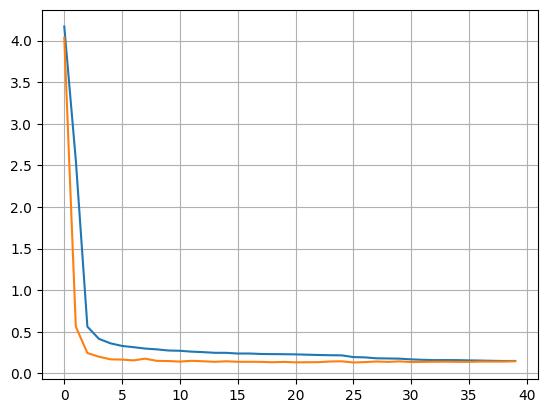

In [5]:
plt.plot(lst_loss_train)
plt.plot(lst_loss_val)
plt.grid()
plt.show()

In [6]:
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu() 
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy() # арзмакс по лагитам и преобразование к словарю
    
    for ind in max_inds:
        merged_inds = []
        for idx in ind:
            if idx != blank_label_idx: 
                merged_inds.append(idx)
        text = "".join([int_char_map.get(i, '?') for i in merged_inds])
        preds.append(text)

    return preds

model_load = MorseNet(num_classes=num_classes)
model_load.load_state_dict(torch.load('MorseNet.pth'))
model_load.eval()

with torch.no_grad():
    train_mess = []
    train_predicts = []
    for loader in train_dl:
        seq, test_target, _, mess = loader
        train_mess.extend(mess)

        logits = model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        train_predicts.extend(predicted_values)

    val_mess = []
    val_predicts = []
    for loader in val_dl:
        seq, test_target, _, mess = loader
        val_mess.extend(mess)

        logits= model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        val_predicts.extend(predicted_values)

import Levenshtein

mean_acc_test = np.mean([Levenshtein.ratio(test_pred, train_mess[ind]) for ind, test_pred in enumerate(train_predicts)])
mean_acc_val = np.mean([Levenshtein.ratio(val_pred, val_mess[ind]) for ind, val_pred in enumerate(val_predicts)])


print(f"Mean accurasu by The Levenshtein in train is : {mean_acc_test}")
print(f"Mean accurasu by The Levenshtein in validate is : {mean_acc_val}")

CNN размерность выхода: torch.Size([1, 32, 16, 89])
CNN число фичей: 512
Проекция из 512 в 512
Mean accurasu by The Levenshtein in train is : 0.9306204623520523
Mean accurasu by The Levenshtein in validate is : 0.9449027945915751


# Сбор sample_submission

In [7]:
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu() 
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy() # арзмакс по лагитам и преобразование к словарю
    
    for ind in max_inds:
        merged_inds = []
        for idx in ind:
            if idx != blank_label_idx: 
                merged_inds.append(idx)
        text = "".join([int_char_map.get(i, '?') for i in merged_inds])
        preds.append(text)

    return preds

model_load = MorseNet(num_classes=num_classes)
model_load.load_state_dict(torch.load('MorseNet.pth'))
model_load.eval()

test_ds = MosreDataset(df=sample_data,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=False,
                        transforms=valid_audio_transforms)


test_dl = torch.utils.data.DataLoader(test_ds, batch_size=20, shuffle=False, collate_fn=my_collate)
model_load.eval()

with torch.no_grad():
    test_predicts = []
    for loader in test_dl:
        seq = loader
        logits = model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        test_predicts.extend(predicted_values)

sample_data.message = test_predicts
sample_data.to_csv('sample_submission.csv', index=False)

CNN размерность выхода: torch.Size([1, 32, 16, 89])
CNN число фичей: 512
Проекция из 512 в 512
